In [47]:
# file related
import os
from os.path import join

# machine learning
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split

# utils
import numpy as np
import matplotlib.pyplot as plt
import random
import librosa
import import_ipynb
from IPython.display import Audio as play_audio
import scipy as sp
import matplotlib.patches as patches
%run transient_shaper_lib.ipynb

# print(f"TF version {tf.__version__}")

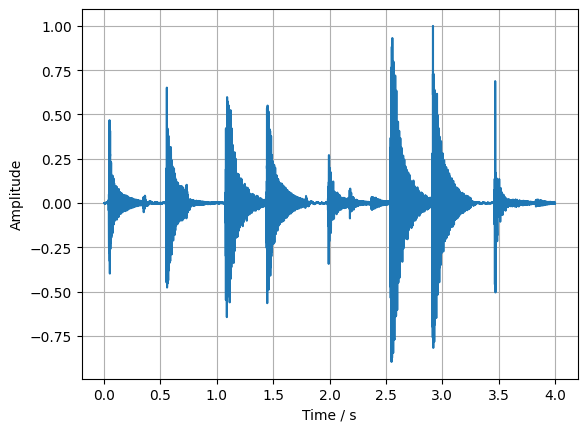

In [48]:
WIN_LEN = 4
fs, x = sp.io.wavfile.read("congas_82_25_1.wav")
try:
    x = x[:WIN_LEN*fs, 0]
except:
    x = x[:WIN_LEN*fs]
num_samples = len(x)
n_bits = 32
x = x / (2**n_bits / 2)

# normalize
x /= np.max(x)

t = np.linspace(0, num_samples- 1, num_samples) / fs

plt.plot(t, x)
plt.xlabel("Time / s")
plt.ylabel("Amplitude")
plt.grid()

In [49]:
def getMinima(env, searchStep=4000):
    return sp.signal.find_peaks(env *(-1), distance=searchStep)[0]

def getMaxima(env, searchStep=4000):
    return sp.signal.find_peaks(env, distance=searchStep)[0]

def getPeakIdx(env):
    return np.argmax(env)

def getSurroundMinIdx(env, peakIdx, searchStep=4000):
    minima = getMinima(env, searchStep)
    startIdx = max(minima, key=lambda x: x if x < peakIdx else float('-inf'))
    stopIdx = min(minima, key=lambda x: x if x > peakIdx else float('inf'))
    if stopIdx < peakIdx or env[stopIdx] < env[startIdx]:
        # sound fades out
        stopIdx = len(env) - 1
    return (startIdx, stopIdx)

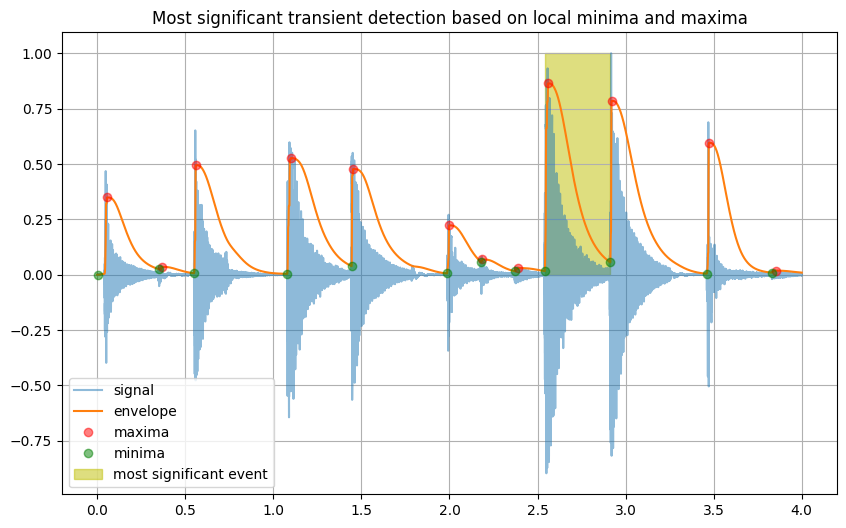

In [50]:
order = 4
attack = 2
release = 200

smooth_fast = ExpSmooth(order)
smooth_fast.reset(fs)
smooth_fast.set_attack(attack)
smooth_fast.set_release(release)

env_smooth = np.zeros(num_samples)

for i, sample in enumerate(x):
    env_smooth[i] = smooth_fast.process(sample)

start, stop = getSurroundMinIdx(env_smooth, getPeakIdx(env_smooth))
rect = patches.Rectangle((start/fs, 
                          0), 
                          stop/fs - start/fs, 
                          np.max(x),
                          linewidth=1, 
                          edgecolor='y', 
                          facecolor='y', 
                          alpha=0.5,
                          label="most significant event")

minima = getMinima(env_smooth)
maxima = getMaxima(env_smooth)

plt.figure(figsize=(10, 6))
plt.title("Most significant transient detection based on local minima and maxima")
plt.plot(t, x, label="signal", alpha=0.5)
plt.plot(t, env_smooth, label="envelope")
plt.plot(maxima/fs, env_smooth[maxima], "ro", label="maxima", alpha=0.5)
plt.plot(minima/fs, env_smooth[minima], "go", label="minima", alpha=0.5)
plt.gca().add_patch(rect)
plt.grid()
plt.legend()

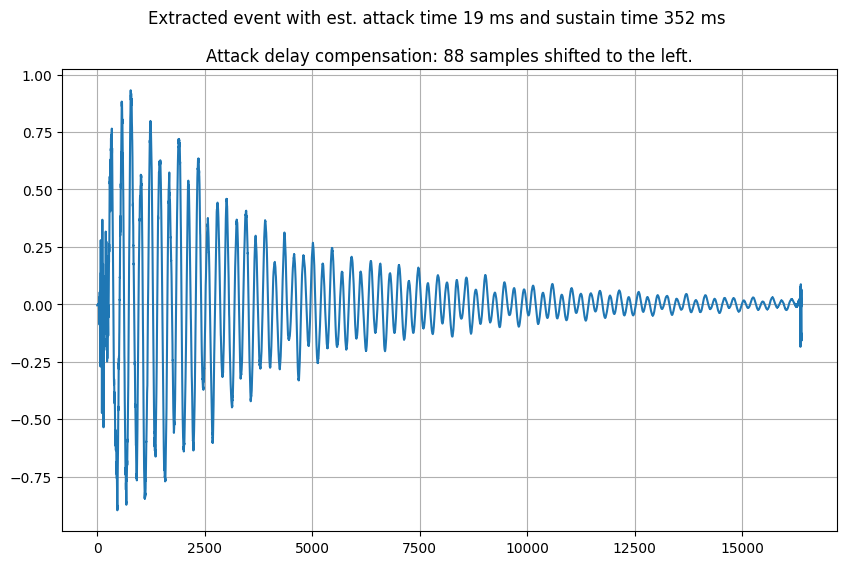

In [51]:
# prepend some time to account for the attack time
onsetSamples = int((attack / 1000) * fs)
attackTime = int((getPeakIdx(env_smooth) - start) / fs * 1000)
sustainTime = int((stop - getPeakIdx(env_smooth)) / fs * 1000)

plt.figure(figsize=(10, 6))
plt.suptitle(f"Extracted event with est. attack time {attackTime} ms and sustain time {sustainTime} ms")
plt.title(f"Attack delay compensation: {onsetSamples} samples shifted to the left.")
plt.grid()
plt.plot(x[start-onsetSamples:stop-onsetSamples])

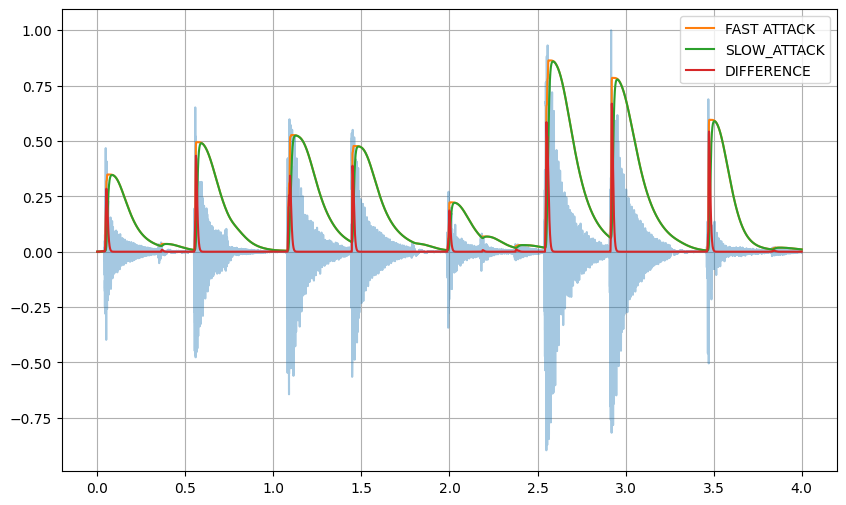

In [52]:
# use the obtained values with the env-follower used in TD
smooth_fast = ExpSmooth(4)
smooth_fast.reset(fs)
smooth_fast.set_attack(2)       # keep this as default
smooth_fast.set_release(20)

smooth_slow = ExpSmooth(4)
smooth_slow.reset(fs)
smooth_slow.set_attack(attackTime)      # this is where the computed value is inserted
smooth_slow.set_release(20)

env_fast = np.zeros(num_samples)
env_slow = np.zeros(num_samples)
for n, sample in enumerate(env_smooth):
    env_fast[n] = smooth_fast.process(sample)
    env_slow[n] = smooth_slow.process(sample)

plt.figure(figsize=(10, 6))
plt.plot(t, x, alpha = 0.4)
# plt.plot(t, env_peak_hold, label="PEAK-HOLD")
plt.plot(t, env_fast, label="FAST ATTACK")
plt.plot(t, env_slow, label="SLOW_ATTACK")

# Find difference
env_diff = env_fast - env_slow
plt.plot(t, env_diff, label="DIFFERENCE")

plt.grid()
plt.legend()

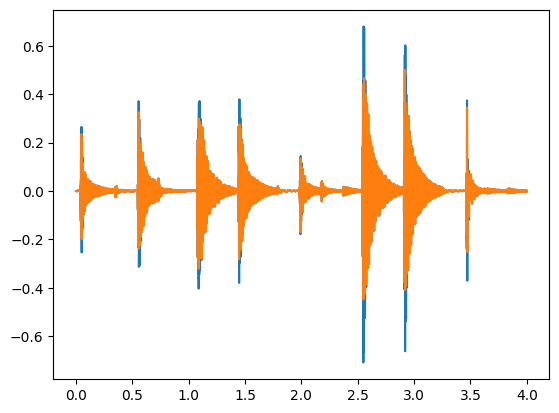

In [53]:
# Scale down input to give 6dB headroom
X_scaled = x / 2.0

# Apply
X_att = X_scaled * (1.0 + env_diff)

plt.plot(t, X_att)
plt.plot(t, X_scaled)

display(play_audio(X_scaled, rate=fs, normalize=False))
display(play_audio(X_att, rate=fs, normalize=False))

sp.io.wavfile.write("renders/clean.wav", fs, X_scaled)
sp.io.wavfile.write("renders/att_6db.wav", fs, X_att)

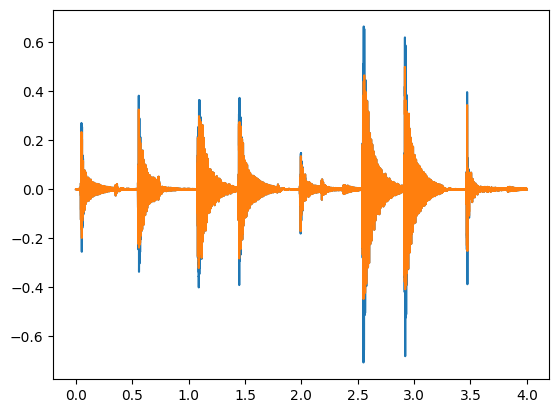

In [54]:
""" Amplify attack by 6dB for test with lookahead """

# Delay input signal (lookahead)
def delay(data, time, sample_rate):
    time = time / 1000.0
    samples_delay = int(time * sample_rate)
    data_delayed = np.zeros(len(data) + samples_delay)
    for n, x in enumerate(data):
        data_delayed[n + samples_delay] = x

    return data_delayed

X_delayed = delay(x, 1.0, fs)
X_delayed_scaled = X_delayed / 2.0
X_delayed_scaled = X_delayed_scaled[:len(t)]

# Apply
X_att = X_delayed_scaled * (1.0 + env_diff)

plt.plot(t, X_att)
plt.plot(t, X_delayed_scaled)

display(play_audio(X_scaled, rate=fs, normalize=False))
display(play_audio(X_att, rate=fs, normalize=False))

sp.io.wavfile.write("renders/clean.wav", fs, X_scaled)
sp.io.wavfile.write("renders/att_6db.wav", fs, X_att)

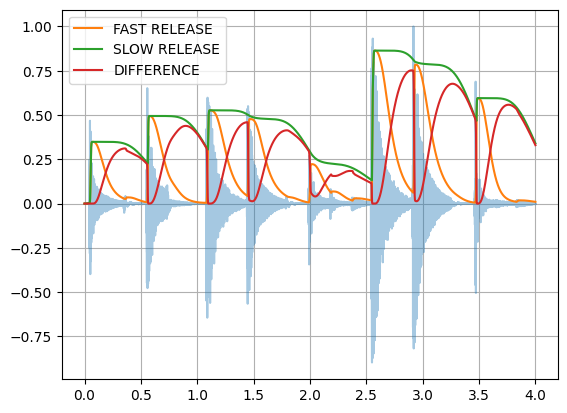

In [56]:
""" Smooth peak-held env RELEASE """

smooth_fast = ExpSmooth(8)
smooth_fast.reset(fs)
smooth_fast.set_attack(5)
smooth_fast.set_release(10)

smooth_slow = ExpSmooth(8)
smooth_slow.reset(fs)
smooth_slow.set_attack(5)
smooth_slow.set_release(sustainTime)

env_fast = np.zeros(num_samples)
env_slow = np.zeros(num_samples)
for n, sample in enumerate(env_smooth):
    env_fast[n] = smooth_fast.process(sample)
    env_slow[n] = smooth_slow.process(sample)

plt.plot(t, x, alpha = 0.4)
# plt.plot(t, env_peak_hold, label="PEAK-HOLD")
plt.plot(t, env_fast, label="FAST RELEASE")
plt.plot(t, env_slow, label="SLOW RELEASE")

# Find difference
env_diff = env_slow - env_fast
plt.plot(t, env_diff, label="DIFFERENCE")

plt.grid()
plt.legend()